In [ ]:
import cv2
import numpy as np
import sys
import collections
import math
import json
import os
import io
from collections import defaultdict
from google.colab.patches import cv2_imshow

In [ ]:
im_num = "0053"
image = cv2.imread(im_num+'.png')
img = image

In [ ]:
img.shape

(800, 1200, 3)

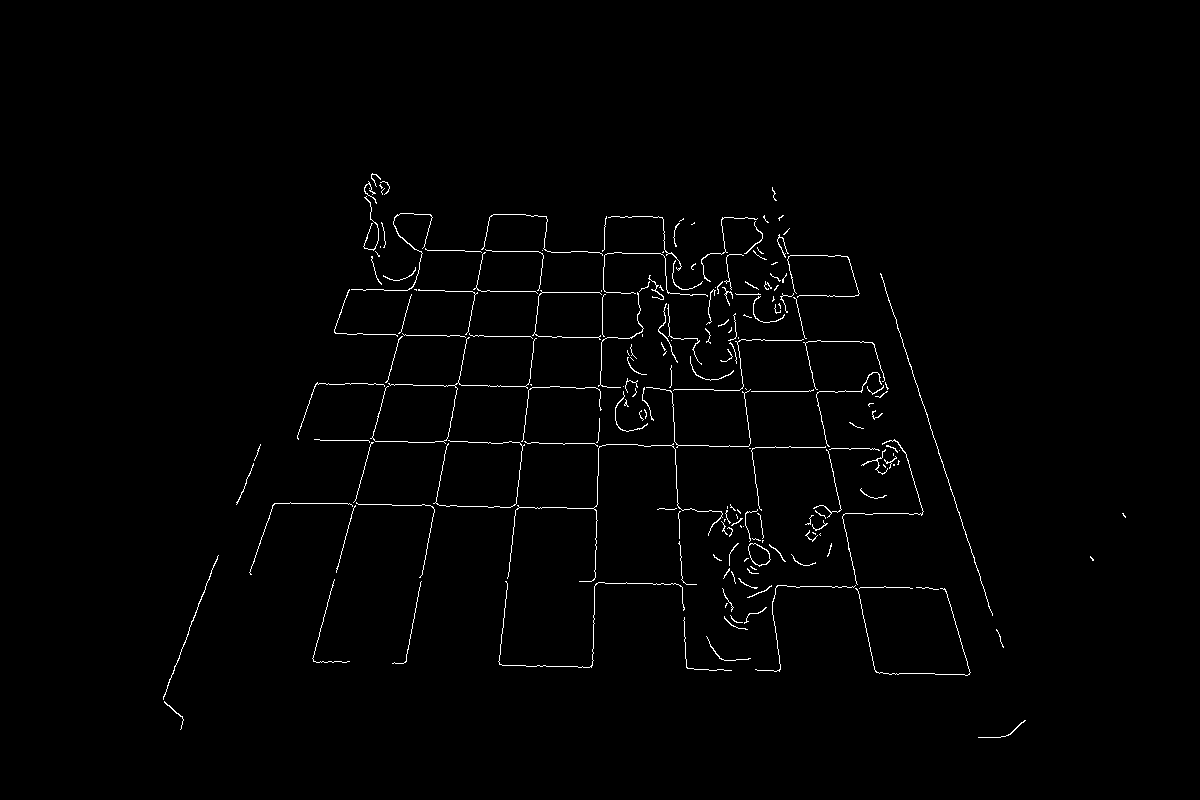

In [ ]:
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
 
# Use canny edge detection
# ksize
ksize = (4, 5)
  
# Using cv2.blur() method 
gray = cv2.blur(gray, ksize) 
edges = cv2.Canny(gray,1150,1550,apertureSize=5)
bin_img = edges
cv2_imshow(edges)

In [ ]:
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """
    Group lines by their angle using k-means clustering.

    Code from here:
    https://stackoverflow.com/a/46572063/1755401
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))

    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # Get angles in [0, pi] radians
    angles = np.array([line[0][1] for line in lines])

    # Multiply the angles by two and find coordinates of that angle on the Unit Circle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)] for angle in angles], dtype=np.float32)

    # Run k-means
    if sys.version_info[0] == 2:
        # python 2.x
        ret, labels, centers = cv2.kmeans(pts, k, criteria, attempts, flags)
    else: 
        # python 3.x, syntax has changed.
        labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]

    labels = labels.reshape(-1) # Transpose to row vector

    # Segment lines based on their label of 0 or 1
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)

    segmented = list(segmented.values())
    print("Segmented lines into two groups: %d, %d" % (len(segmented[0]), len(segmented[1])))

    return segmented


def intersection(line1, line2):
    """
    Find the intersection of two lines 
    specified in Hesse normal form.

    Returns closest integer pixel locations.

    See here:
    https://stackoverflow.com/a/383527/5087436
    """

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))

    return [[x0, y0]]


def segmented_intersections(lines):
    """
    Find the intersection between groups of lines.
    """

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections


def drawLines(img, lines, color=(0,0,255)):
    """
    Draw lines on an image
    """
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img, (x1,y1), (x2,y2), color, 1)


Found lines: 87
Lines kept: 40


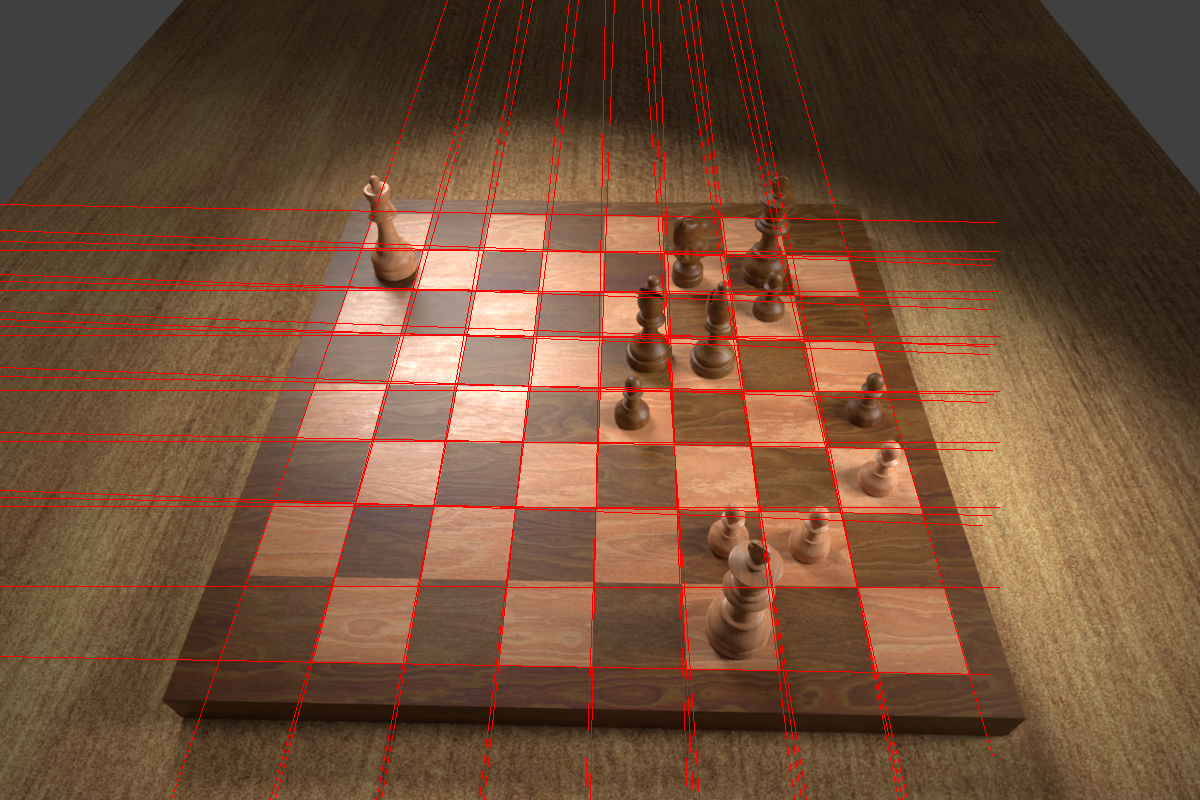

True

In [ ]:
# Detect lines
rho = 1
theta = np.pi/180
thresh = 65
lines = cv2.HoughLines(bin_img, rho, theta, thresh)

if sys.version_info[0] == 2:
    # python 2.x
    # Re-shape from 1xNx2 to Nx1x2
    temp_lines = []
    N = lines.shape[1]
    for i in range(N):
        rho = lines[0,i,0]
        theta = lines[0,i,1]
        temp_lines.append( np.array([[rho,theta]]) )
    lines = temp_lines

filtered_lines = [lines[0]]
for i in range(lines.shape[0]):
  rho = lines[i,0,0]
  theta = lines[i,0,1]
  f = True
  if ( theta>np.pi/180*164 or theta<np.pi/180*20):
    f = False
  if( theta>np.pi/180*89.5 and theta<np.pi/180*92):
    f = False
  if f:
    continue
  for j in filtered_lines:
    flag = False
    if abs(rho - j[0][0]) <= 6.5 and abs(theta - j[0][1]) <= (np.pi/2 - np.pi/180):
      flag = True
      break
  if flag:
    continue
  filtered_lines.append(lines[i])
    
print("Found lines: %d" % (len(lines)))
lines = filtered_lines
print("Lines kept: %d" % (len(lines)))
# Draw all Hough lines in red
img_with_all_lines = np.copy(img)
drawLines(img_with_all_lines, lines)
cv2_imshow(img_with_all_lines)
cv2.waitKey()
cv2.imwrite("all_lines.jpg", img_with_all_lines)

Segmented lines into two groups: 19, 21


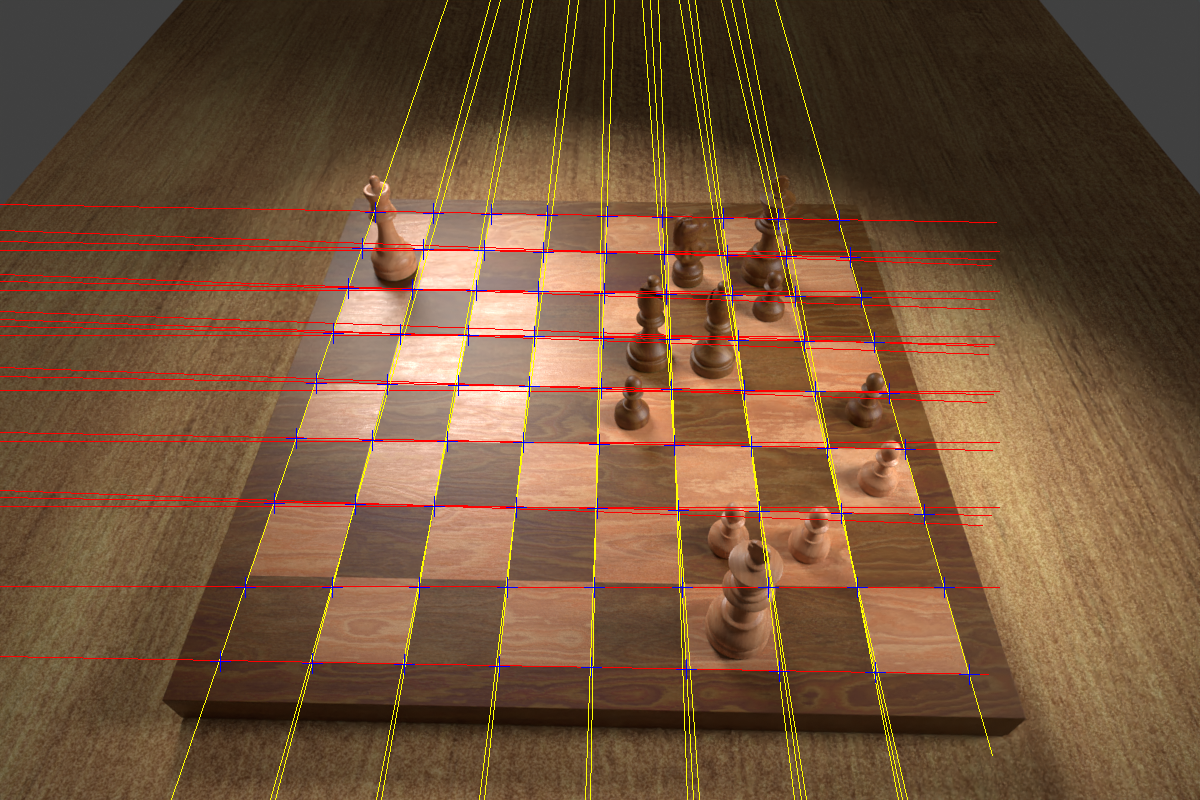

True

In [ ]:
# Cluster line angles into 2 groups (vertical and horizontal)
segmented = segment_by_angle_kmeans(lines, 2)

# Find the intersections of each vertical line with each horizontal line
intersections = segmented_intersections(segmented)

img_with_segmented_lines = np.copy(img)

# Draw vertical lines in red
vertical_lines = segmented[1]
img_with_vertical_lines = np.copy(img)
drawLines(img_with_segmented_lines, vertical_lines, (0,0,255))

# Draw horizontal lines in yellow
horizontal_lines = segmented[0]
img_with_horizontal_lines = np.copy(img)
drawLines(img_with_segmented_lines, horizontal_lines, (0,255,255))

# Draw intersection points in blue
points = []
thresh = 15
for point in intersections:
    flag = False
    if points:
      for i in points:
        if ((abs(point[0][0] - i[0]) <= thresh) and (abs(point[0][1] - i[1]) <= thresh)) or abs(point[0][0] - i[0]) >= 1600:
          flag = True
          break
    if(flag):
      continue
    pt = (point[0][0], point[0][1])
    points.append(pt)
    length = 10
    cv2.line(img_with_segmented_lines, (pt[0], pt[1]-length), (pt[0], pt[1]+length), (255, 0, 0), 1) # vertical line
    cv2.line(img_with_segmented_lines, (pt[0]-length, pt[1]), (pt[0]+length, pt[1]), (255, 0, 0), 1)

cv2_imshow(img_with_segmented_lines)
cv2.waitKey()
cv2.imwrite("intersection_points.jpg", img_with_segmented_lines)

In [ ]:
points.sort(key=lambda k: [k[1], k[0]])

In [ ]:
def angle_between_points(p1, p2):
    d1 = p2[0] - p1[0]
    d2 = p2[1] - p1[1]
    if d1 == 0:
        if d2 == 0:  # same points?
            deg = 0
        else:
            deg = 0 if p1[1] > p2[1] else 180
    elif d2 == 0:
        deg = 90 if p1[0] < p2[0] else 270
    else:
        deg = math.atan(d2 / d1) / np.pi * 180
        lowering = p1[1] < p2[1]
        if (lowering and deg < 0) or (not lowering and deg > 0):
            deg += 270
        else:
            deg += 90
    return deg

In [ ]:
rows, cols = (8, 8)
squares = [[None]*rows for _ in range(cols)]

In [ ]:
#identify squares by angle between corners
r = 0
c = 0
for i in range(len(points)):
  for j in range(i,i+16):
    if r > 7:
      break
    if j == i:
      continue
    if(j >= len(points)):
      break
    a = angle_between_points(points[i], points[j])
    if a < 145 and a > 115:
      squares[r][c] = [points[i][0], points[i][1], points[j][0], points[j][1]]
      if c != 7:
        c += 1
      else:
        c = 0
        r += 1
      break

In [ ]:
def board_to_fen(board):
    # Use StringIO to build string more efficiently than concatenating
    with io.StringIO() as s:
        for row in board:
            empty = 0
            for cell in row:
                c = cell[0]
                if c not in ('.'):
                    if empty > 0:
                        s.write(str(empty))
                        empty = 0
                    s.write(c)
                else:
                    empty += 1
            if empty > 0:
                s.write(str(empty))
            s.write('/')
        # Move one position back to overwrite last '/'
        s.seek(s.tell() - 1)
        # If you do not have the additional information choose what to put
        s.write(' w KQkq - 0 1')
        return s.getvalue()

In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
board = [['.']*rows for _ in range(cols)] 
pred = []
pred_labels = []
placed = []
with open(im_num+".txt") as f:
  for line in f:
        l = line.split(' ')
        x1 = (float(l[1])-.045)*img.shape[1] - (float(l[3])-.045)*img.shape[1]
        y1 = (float(l[2])-.05)*img.shape[0] - (float(l[4])-.05)*img.shape[0]
        x2 = (float(l[1])-.045)*img.shape[1] + (float(l[3])-.045)*img.shape[1]
        y2 = (float(l[2])-.05)*img.shape[0] + (float(l[4])-.05)*img.shape[0]
        if l[0] == '0':
          label = 'k'
        elif l[0] == '1':
          label = 'q'
        elif l[0] == '2':
          label = 'r'
        elif l[0] == '3':
          label = 'b'
        elif l[0] == '4':
          label = 'n'
        elif l[0] == '5':
          label = 'p'
        elif l[0] == '6':
          label = 'K'
        elif l[0] == '7':
          label = 'Q'
        elif l[0] == '8':
          label = 'R'
        elif l[0] == '9':
          label = 'B'
        elif l[0] == '10':
          label = 'N'
        elif l[0] == '11':
          label = 'P'
        pred_labels.append(label)
        pred.append([x1,y1,x2,y2])

for i in range(len(pred)):
  best = 0
  br = -1
  bc = -1
  for r in range(rows):
    for c in range(cols):
        if([r,c] in placed):
          continue
        iou = get_iou(squares[r][c],pred[i])
        if iou > best:
          best = iou
          br = r
          bc = c
  if(br >= 0 and bc >= 0):
    board[br][bc] = pred_labels[i]
    placed.append([br,bc])
        

In [ ]:
board

[['.', '.', '.', '.', '.', '.', 'p', '.'],
 ['Q', '.', '.', '.', 'n', 'k', '.', '.'],
 ['.', '.', '.', '.', 'b', 'p', '.', '.'],
 ['.', '.', '.', 'p', '.', 'b', '.', 'p'],
 ['.', '.', '.', '.', '.', '.', '.', 'P'],
 ['.', '.', '.', '.', '.', 'P', 'P', '.'],
 ['.', '.', '.', '.', '.', 'K', '.', '.'],
 ['.', '.', '.', '.', '.', '.', '.', '.']]

In [ ]:
fen = board_to_fen(board)
print(fen)

6p1/Q3nk2/4bp2/3p1b1p/7P/5PP1/5K2/8 w KQkq - 0 1
